Imports
-----

In [68]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from tqdm import tqdm 

import matplotlib.pyplot as plt

import random



## Initialise the network and set the board size 
size_board = 4 
env=Chess_Env(size_board)

Neural Network implementation
========================================================

In [69]:
def network(X, Theta):
  W1, W2 = Theta

  # compute activation
  A = np.matmul(W1, X)
  # compute hidden unit output
  H = np.tanh(A)
  H[0] = 1
  # compute network output
  Y = np.dot(W2, H)
  return Y, H

def gradient(X, T, Y, H, Theta):
  W1, W2 = Theta
  g1 = np.dot((np.dot(W2.T,(Y-T))*(1-H**2)),X.T)
  g2 = (np.dot((Y-T),H.T))
  return g1, g2

def gradient_descent(X, y, h, T, Theta, eta):
  (W1, W2) = Theta
  (g1, g2) = gradient(X, T, y, h, (W1, W2))
  W1 += -eta * g1 
  W2 += -eta * g2
  return W1, W2  

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






Neural Network Initialisation (Policy network)
----------------------------

In [70]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...

S,X,allowed_a=env.Initialise_game()

#N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
a,_=np.where(allowed_a==1)

X = np.insert(X,0,1).reshape(-1,1) # adding bias term

N_a = len(allowed_a)   ## Number of allowed actions. Will also include the actions that are not possible considering other pieces. 
N_in = np.shape(X)[0]    ## INPUT SIZE
N_h = 200                ## NUMBER OF HIDDEN NODES

Neural Network declarations
-------------

In [71]:
np.random.seed(91) # for reproducability of the code

K = N_h #number of hidden nodes
D = len(X)
O = N_a # number of outputs equal to the number of allowed actions.

W1 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (K,D)) #defining the initial weights
W2 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (O,K)) #defining the initial weights
Theta = [W1, W2] #combined to be used as an input to the neural network

Target Network(Clone of the Policy Network)
-----

In [72]:
#Clone the Neural network to find optimal q value 

W1_clone = np.copy(W1) #
W2_clone = np.copy(W2) 
Theta_clone = [W1_clone, W2_clone]

Hyperparameters
-----

In [73]:
# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.05      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85       # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
N_episodes =  50000 # THE NUMBER OF GAMES TO BE PLAYED 

Defining arrays to be used for plotting
-----

In [74]:

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])
time_per_episode = np.zeros([N_episodes, 1])
win_or_draw = np.empty(N_episodes,dtype="object")

#  Algorithm 1 --> SARSA

Training block SARSA
-----

In [75]:
import time
clone_update = 0 #counter that is used to clone the weights of the Policy network after certain episodes, to be then used for training network. 
for n in tqdm(range(N_episodes)):
    start_time = time.time() #get the time taken to complete each episode
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    Total_rewards = 0                        ## Keeps track of the total rewards per episode 
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

    S, X, allowed_a=env.Initialise_game()      ## INITIALISE GAME

    X = np.insert(X,0,1).reshape(-1,1) # adding bias term

    while Done==0:                           ## The game has neither drawn nor been won

        q_values, H = network(X,Theta) #through the forward propagation, get the qvalues 
        a,_=np.where(allowed_a==1) #get the indexes between 0 and 31 to show which of these actions are allowed

        q_values_epsilon = np.copy(q_values) #store the received qvalues separately which will be used for the greedy epsilon selection 
        q_values_epsilon[allowed_a==0] = -9999999 # the qvalues on the indices/actions which are not allowed has to be set to minimum value. 
        
        # EXPLORATION VS EXPLOITATION
        if np.random.random() < epsilon_f :
            a_agent = np.random.permutation(a)[0] #randomly takes an action from the list of available actions 
            
        else:
            a_agent = np.argmax(q_values_epsilon) #takes the action which corresponds to the value of the highest qvalue 
    
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) #Now since we have the action that we want to take, we will pass it to the OneStep function to get the next state, Reward, the next feature vector and the vector showing the possible actions that can be taken
        X_next = np.insert(X_next,0,1).reshape(-1,1) # adding bias term
        
        ## THE EPISODE HAS ENDED
        if Done==1:
            #print('done')
            if R==5:
                flag = 'Win'
            else:
                flag = 'Draw'    
 
            target_q_value =  R + (np.max(network(np.zeros_like(X), Theta_clone)[0]))
            target_vector = np.copy(q_values) 
            target_vector[a_agent] = target_q_value #using the one-hot encoded current state, and the target value converted as a vector to train the model on a single step.

            W1, W2 = gradient_descent(X, q_values, H, target_vector, Theta, eta = eta) #run gradient descent 
            Theta = [W1, W2]

        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING
            q_value_next, h_next = network(X_next,Theta_clone) #using the train network (clone of the policy network), to find the future value of q so that we can chose the best action in the future state which will give us the best reward
            a_next,_=np.where(allowed_a_next==1) #get the indexes between 0 and 31 to show which of these actions are allowed
            q_value_epsilon_next = np.copy(q_value_next) #store the received qvalues separately which will be used for the greedy epsilon selection 
            q_value_epsilon_next[allowed_a_next==0] = -9999999
            #a_agent_next = np.max(q_value_next) # optimal future q value
                    # EXPLORATION VS EXPLOITATION
            if np.random.random() < epsilon_f :
                a_agent_next = np.random.permutation(a_next)[0] #randomly takes an action from the list of available actions 
                
            else:
                a_agent_next = np.argmax(q_value_epsilon_next) #takes the action which corresponds to the value of the highest qvalue 

            target_q_value = (gamma * q_value_epsilon_next[a_agent_next]) + R  # get the target value based on the Bellman equation using the model prediction for the next state
            target_vector = np.copy(q_values)
            target_vector[a_agent] = target_q_value # use the one-hot encoded current state, and the target value converted as a vector to train the model on a single step.

            W1, W2 = gradient_descent(X, q_values, H, target_vector, Theta, eta = eta) # run gradient descent to get the updated weights
            Theta = [W1, W2] 
           
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next) # the next state now becomes the current state 
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)
            
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        Total_rewards += R #get total rewards collected after the game/episode ends(either drawn or won)
            #print('i:',i)

    #print('Total_rewards for the episode:',Total_rewards)  
    #print('Total steps for the episode:',i)   

    R_save[n]=np.copy(Total_rewards) #save total rewards for this episode 
    N_moves_save[n]=np.copy(i) # save total number of moves used for this episode
    win_or_draw[n] = np.copy(flag) #saves if this episode was won or drawn

    # This parts increments the value of the counter and will clone the weights of the theta after 50 episodes have been reached
    clone_update+=1
    if clone_update==50:
        Theta_clone = Theta
        clone_update = 0

    #time_per_episode[n] =   time.time() - start_time
    time_per_episode[n] =   time.time()


100%|██████████| 50000/50000 [02:26<00:00, 341.61it/s]


Plots SARSA
-----

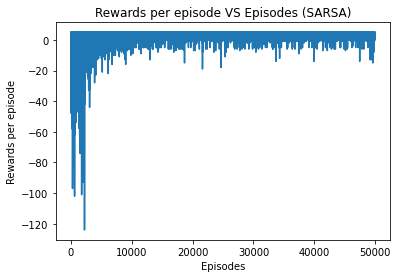

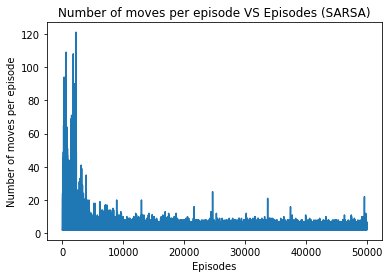

In [76]:
episodes_prog = np.arange(0,N_episodes,1)

plt.plot(episodes_prog, R_save) # Create line plot with yvals against xvals
plt.title('Rewards per episode VS Episodes (SARSA)')
plt.xlabel('Episodes')
plt.ylabel('Rewards per episode')
plt.show()

plt.plot(episodes_prog, N_moves_save) # Create line plot with yvals against xvals
plt.title('Number of moves per episode VS Episodes (SARSA)')
plt.xlabel('Episodes')
plt.ylabel('Number of moves per episode')
plt.show()



Results SARSA
------

In [84]:
print('Random_Agent, Average reward:',np.mean(R_save[-10000:]),'Number of steps: ',np.mean(N_moves_save[-10000:])) #gets the average reward and the average number of steps taken for the last 100 episodes
unique, counts = np.unique(win_or_draw[-100:], return_counts=True)
print (np.asarray((unique, counts)).T) #gets the number of time our algorithm won or draws 


Random_Agent, Average reward: 3.5538 Number of steps:  3.4102
[[array('Win', dtype='<U3') 100]]


#  Algorithm 2 --> Q Learning 

Initialisations for Q Learning
----

In [86]:
np.random.seed(92) # for reproducability of the code

# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...

S,X,allowed_a=env.Initialise_game()

#N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
a,_=np.where(allowed_a==1)

X = np.insert(X,0,1).reshape(-1,1) # adding bias term

N_a = len(allowed_a)   ## Number of allowed actions. Will also include the actions that are not possible considering other pieces. 
N_in = np.shape(X)[0]    ## INPUT SIZE
N_h = 200                ## NUMBER OF HIDDEN NODES

#setting up Neural network essentials

K = N_h #number of hidden nodes
D = len(X)
O = N_a # number of outputs equal to the number of allowed actions.

W1 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (K,D)) #defining the initial weights
W2 = np.random.uniform(-1/np.sqrt(D), 1/np.sqrt(D), (O,K)) #defining the initial weights
Theta = [W1, W2] #combined to be used as an input to the neural network
#Clone the Neural network to find optimal q value 

W1_clone = np.copy(W1) #
W2_clone = np.copy(W2) 
Theta_clone = [W1_clone, W2_clone]


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.05      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
N_episodes =  50000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])
time_per_episode = np.zeros([N_episodes, 1])
win_or_draw = np.empty(N_episodes,dtype="object")

Training block Q Learning
----

In [87]:
import time
clone_update = 0 #counter that is used to clone the weights of the Policy network after certain episodes, to be then used for training network. 
for n in tqdm(range(N_episodes)):
    start_time = time.time() #get the time taken to complete each episode
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    Total_rewards = 0                        ## Keeps track of the total rewards per episode 
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

    S, X, allowed_a=env.Initialise_game()      ## INITIALISE GAME

    X = np.insert(X,0,1).reshape(-1,1) # adding bias term

    while Done==0:                           ## The game has neither drawn nor been won

        q_values, H = network(X,Theta) #through the forward propagation, get the qvalues 
        a,_=np.where(allowed_a==1) #get the indexes between 0 and 31 to show which of these actions are allowed

        q_values_epsilon = np.copy(q_values) #store the received qvalues separately which will be used for the greedy epsilon selection 
        q_values_epsilon[allowed_a==0] = -9999999 # the qvalues on the indices/actions which are not allowed has to be set to minimum value. 
        
        # EXPLORATION VS EXPLOITATION
        if np.random.random() < epsilon_f :
            a_agent = np.random.permutation(a)[0] #randomly takes an action from the list of available actions 
            
        else:
            a_agent = np.argmax(q_values_epsilon) #takes the action which corresponds to the value of the highest qvalue 
    
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) #Now since we have the action that we want to take, we will pass it to the OneStep function to get the next state, Reward, the next feature vector and the vector showing the possible actions that can be taken
        X_next = np.insert(X_next,0,1).reshape(-1,1) # adding bias term
        
        ## THE EPISODE HAS ENDED
        if Done==1:
            #print('done')
            if R==5:
                flag = 'Win'
            else:
                flag = 'Draw'    
 
            target_q_value =  R + (np.max(network(np.zeros_like(X), Theta_clone)[0]))
            target_vector = np.copy(q_values) 
            target_vector[a_agent] = target_q_value #using the one-hot encoded current state, and the target value converted as a vector to train the model on a single step.

            W1, W2 = gradient_descent(X, q_values, H, target_vector, Theta, eta = eta) #run gradient descent 
            Theta = [W1, W2]

        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING
            q_value_next, h_next = network(X_next,Theta_clone) #using the train network (clone of the policy network), to find the future value of q so that we can chose the best action in the future state which will give us the best reward
            q_value_next[allowed_a_next==0] = -9999999
            a_agent_next = np.max(q_value_next) # optimal future q value

            target_q_value = (gamma * a_agent_next) + R  # get the target value based on the Bellman equation using the model prediction for the next state
            target_vector = np.copy(q_values)
            target_vector[a_agent] = target_q_value # use the one-hot encoded current state, and the target value converted as a vector to train the model on a single step.

            W1, W2 = gradient_descent(X, q_values, H, target_vector, Theta, eta = eta) # run gradient descent to get the updated weights
            Theta = [W1, W2] 
           
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next) # the next state now becomes the current state 
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)
            
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
        Total_rewards += R #get total rewards collected after the game/episode ends(either drawn or won)
            #print('i:',i)

    #print('Total_rewards for the episode:',Total_rewards)  
    #print('Total steps for the episode:',i)   

    R_save[n]=np.copy(Total_rewards) #save total rewards for this episode 
    N_moves_save[n]=np.copy(i) # save total number of moves used for this episode
    win_or_draw[n] = np.copy(flag) #saves if this episode was won or drawn

    # This parts increments the value of the counter and will clone the weights of the theta after 50 episodes have been reached
    clone_update+=1
    if clone_update==50:
        Theta_clone = Theta
        clone_update = 0

    #time_per_episode[n] =   time.time() - start_time
    time_per_episode[n] =   time.time()


100%|██████████| 50000/50000 [02:32<00:00, 328.80it/s]


Plots Q Learning
-----

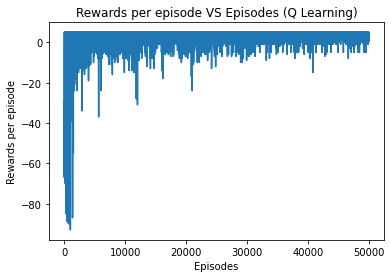

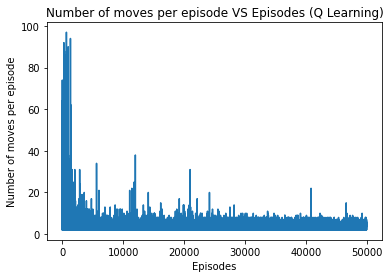

In [88]:
episodes_prog = np.arange(0,N_episodes,1)

plt.plot(episodes_prog, R_save) # Create line plot with yvals against xvals
plt.title('Rewards per episode VS Episodes (Q Learning)')
plt.xlabel('Episodes')
plt.ylabel('Rewards per episode')
plt.show()

plt.plot(episodes_prog, N_moves_save) # Create line plot with yvals against xvals
plt.title('Number of moves per episode VS Episodes (Q Learning)')
plt.xlabel('Episodes')
plt.ylabel('Number of moves per episode')
plt.show()


Results Q Learning
------

In [90]:
print('Random_Agent, Average reward:',np.mean(R_save[-20000:]),'Number of steps: ',np.mean(N_moves_save[-20000:])) #gets the average reward and the average number of steps taken for the last 100 episodes
unique, counts = np.unique(win_or_draw[-100:], return_counts=True)
print (np.asarray((unique, counts)).T) #gets the number of time our algorithm won or draws 


Random_Agent, Average reward: 3.57815 Number of steps:  3.39735
[[array('Win', dtype='<U3') 100]]
